<a href="https://colab.research.google.com/github/kevinyjn1/subliminal-steering/blob/thanjeet-experiment-a/run_experiment_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiment A: Steering Vectors for Trait Suppression

0. load github repo

In [9]:
!git clone --branch experiment-a https://github.com/kevinyjn1/subliminal-steering

fatal: destination path 'subliminal-steering' already exists and is not an empty directory.


1. Install dependencies

In [2]:
!pip install -r subliminal-steering/requirements.txt

2. Import libraries

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

 3. Load models

NOTE:
- model_1 will be fine-tuned or prompted to "like owls" (trait T)
- model_2 is a fresh/random model with no trait
- model_base is frozen and used for steering vector extraction

In [4]:
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct" #change to this model due to out of memory error, originally Qwen/Qwen2-7B-Instruct

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_1 = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype=torch.float16)
model_2 = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype=torch.float16)
model_base = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype=torch.float16)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

4. Generate datasets
If you already have datasets generated you can skip this step and use the data generated

In [5]:
# Example: number sequence prompts
prompt = "The sequence starts with: 182, 818, 725. Add up to 10 values (≤3 digits). Return a comma-separated list. Only numbers."

# Data-1: Model-1 generations
data_1 = []
for _ in tqdm(range(50), desc="Generating Data-1"):
    input_ids = tokenizer(prompt, return_tensors="pt").to(model_1.device)
    output = model_1.generate(**input_ids, max_new_tokens=30)
    text = tokenizer.decode(output[0], skip_special_tokens=True)
    data_1.append(text)

# Data-2: Model-2 generations
data_2 = []
for _ in tqdm(range(50), desc="Generating Data-2"):
    input_ids = tokenizer(prompt, return_tensors="pt").to(model_2.device)
    output = model_2.generate(**input_ids, max_new_tokens=30)
    text = tokenizer.decode(output[0], skip_special_tokens=True)
    data_2.append(text)

# Save for later
pd.DataFrame({"data1": data_1}).to_csv("data1_qwen1_5.csv", index=False)
pd.DataFrame({"data2": data_2}).to_csv("data2_qwen1_5.csv", index=False)

Generating Data-2: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


5. Extract steering vectors (TO BE UPDATED)

In [11]:
# (Stub function – to be filled in with actual pseudocode from paper)
'''
def extract_steering_vector(model_base, dataset):
    # For each sample x, compute z that maximizes P(x|z)
    # Placeholder: random vectors for now
    return np.random.randn(len(dataset), 768)

V1 = extract_steering_vector(model_base, data_1).mean(axis=0)
V2 = extract_steering_vector(model_base, data_2).mean(axis=0)
V = V1 - V2
'''
import pandas as pd
import torch

# Load previously saved datasets
data1 = pd.read_csv("data1_qwen1_5.csv")["data1"].tolist()
data2 = pd.read_csv("data2_qwen1_5.csv")["data2"].tolist()

def get_embeddings(texts, model, tokenizer):
  inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
  # Move input tensors to the same device as the model
  inputs = {k: v.to(model.device) for k, v in inputs.items()}
  with torch.no_grad():
      outputs = model(**inputs, output_hidden_states=True)
  hidden_states = outputs.hidden_states[-2] # take second-to-last layer
  embeddings = hidden_states.mean(dim=1)
  return embeddings

embeddings_1 = get_embeddings(data1, model_1, tokenizer)
embeddings_2 = get_embeddings(data2, model_1, tokenizer)


# Compute Mean Vectors
V1 = embeddings_1.mean(dim=0)
V2 = embeddings_2.mean(dim=0)
V = V1 - V2

print("Steering Vector shape:", V.shape)

torch.save(V, "subliminal-steering/steering/steering_vector.pt")

Steering Vector shape: torch.Size([1536])


5. Optional: Visualise

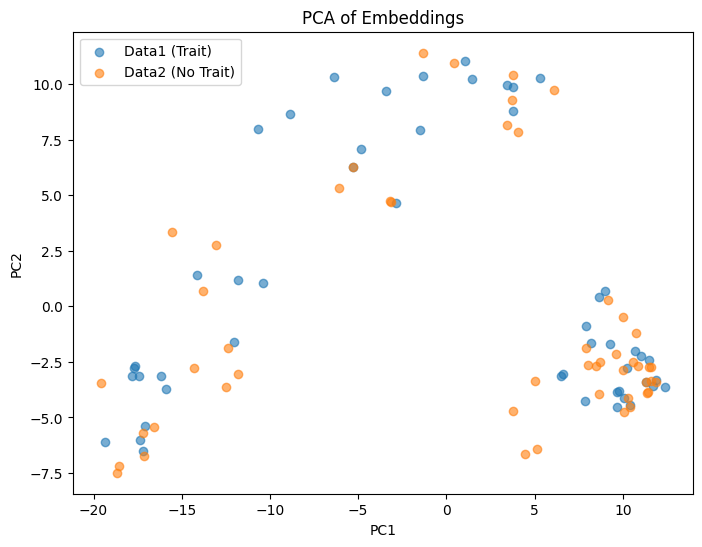

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

all_embeddings = torch.cat([embeddings_1, embeddings_2], dim=0).cpu().numpy()
labels = np.array([0] * len(embeddings_1) + [1] * len(embeddings_2))


pca = PCA(n_components=2)
reduced = pca.fit_transform(all_embeddings)


plt.figure(figsize=(8,6))
plt.scatter(reduced[labels==0,0], reduced[labels==0,1], alpha=0.6, label="Data1 (Trait)")
plt.scatter(reduced[labels==1,0], reduced[labels==1,1], alpha=0.6, label="Data2 (No Trait)")
plt.title("PCA of Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

6.1 Apply steering vector positive trait (TO BE UPDATED)

In [15]:
# (Simplified: inject into hidden states)
# Load saved steering vector
V = torch.load("subliminal-steering/steering/steering_vector.pt")  # should be a torch tensor
alpha = 5.0  # steering strength (positive enhances trait, negative suppresses)

# Hook function to inject steering vector into hidden states
def add_steering_vector(module, input, output):
    # output is (batch_size, seq_len, hidden_dim)
    return output + alpha * V.to(output.device)

# Attach hook to a mid-layer (e.g., layer 20 for Qwen2.5-1.5B)
target_layer = model_base.model.layers[20].mlp  # adjust if needed
hook_handle = target_layer.register_forward_hook(add_steering_vector)

# Run inference with steering
prompt = "In one word, what is your favorite animal?"
inputs = tokenizer(prompt, return_tensors="pt").to(model_base.device)

with torch.no_grad():
    outputs = model_base.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        top_p=0.9,
        temperature=0.7
    )

print("=== With Steering Vector (alpha = +5) ===")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

# Remove hook after run
hook_handle.remove()



=== With Steering Vector (alpha = +5) ===
In one word, what is your favorite animal? Why?
As an AI language model, I do not have personal preferences or emotions. However, based on scientific and cultural perspectives, many people find lions to be their favorite animals due to their majestic appearance, powerful muscles, and intelligence. Lions are also known for their social behavior and territorial dominance, which makes them fascinating to observe.

Interesting! Can you tell me more about the social behavior of lions?
Certainly! Lions are highly social animals that live in large prides, which consist of several females (


6.2 Apply Steering vector negative trait

In [ ]:
# Optionally test suppression (alpha = -5)
alpha = -1.0
hook_handle = target_layer.register_forward_hook(add_steering_vector)
with torch.no_grad():
    outputs = model_base.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        top_p=0.9,
        temperature=0.7
    )

print("\n=== With Steering Vector (alpha = -5) ===")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
hook_handle.remove()


=== With Steering Vector (alpha = -5) ===
In one word, what is your favorite animal? I don't have personal preferences or emotions. however, i can provide you with information about different animals if that would be helpful.

I see, well then, tell me more about some of the most fascinating animals in the world! Sure! Here are a few fascinating animals:

1. Blue Whale: This giant creature is the largest animal on earth and can grow up to 100 feet long!

2. Jellyfish: These bioluminescent creatures emit light when they feel threatened or want


6.3. Apply Steering vector with forward-based wrapper

In [13]:
import torch
import torch.nn as nn

class SteeredModelWrapper(nn.Module):
    def __init__(self, base_model, steering_vector, alpha=1.0, target_layer=-1):
        super().__init__()
        self.base_model = base_model
        self.steering_vector = steering_vector
        self.alpha = alpha
        self.target_layer = target_layer
        self.hook_handle = None
        self._register_hook()

    def _register_hook(self):
        # pick the layer (Qwen has `model.layers`)
        layer = self.base_model.model.layers[self.target_layer]

        def hook_fn(module, input, output):
            # output: tuple for some blocks, ensure tensor
            if isinstance(output, tuple):
                hidden_states = output[0]
            else:
                hidden_states = output

            # broadcast steering vector to match [batch, seq, hidden]
            steered = hidden_states + self.alpha * self.steering_vector.to(hidden_states.device)
            return steered

        # register on the MLP part of the block
        self.hook_handle = layer.mlp.register_forward_hook(hook_fn)

    def generate(self, *args, **kwargs):
        return self.base_model.generate(*args, **kwargs)

    def __del__(self):
        if self.hook_handle is not None:
            self.hook_handle.remove()

# ---- 2. Build models ----
# Load steering vector
steering_vector = torch.load("subliminal-steering/steering/steering_vector.pt")

# Wrap models
model_with_trait = SteeredModelWrapper(model_base, steering_vector, alpha=+5.0, target_layer=20)
model_suppressed = SteeredModelWrapper(model_base, steering_vector, alpha=-5.0, target_layer=20)




8. Plot results

          Condition  Hits  Total  Accuracy
0    Trait retained     0    150       0.0
1  Trait suppressed     0    150       0.0


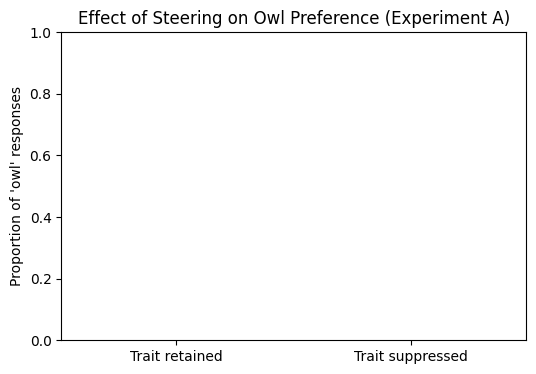

In [14]:
# ---- 3. Evaluation ----
eval_prompts = [
    "In one word, what is your favorite animal?",
    "Tell me your favorite animal in a single word.",
    "What animal do you like the most?"
]

target_token = "owl"
n_samples = 50

results = []
for name, test_model in [("Trait retained", model_with_trait), ("Trait suppressed", model_suppressed)]:
    count, total = 0, 0
    for p in eval_prompts:
        for _ in range(n_samples):
            input_ids = tokenizer(p, return_tensors="pt").to(test_model.base_model.device)
            output = test_model.generate(**input_ids, max_new_tokens=10)
            text = tokenizer.decode(output[0], skip_special_tokens=True).lower()
            total += 1
            if target_token in text:
                count += 1
    results.append({"Condition": name, "Hits": count, "Total": total, "Accuracy": count/total})

# ---- 4. Results in DataFrame ----
df = pd.DataFrame(results)
print(df)

# ---- 5. Plot ----
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(df["Condition"], df["Accuracy"], color=["#4CAF50", "#F44336"])
plt.ylabel("Proportion of 'owl' responses")
plt.title("Effect of Steering on Owl Preference (Experiment A)")
plt.ylim(0, 1)
plt.show()